In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def d1(S,K,T,r,sigma):
    return (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d2(S,K,T,r,sigma):
    return (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def call(S,K,T,r,sigma):
    d_1 = d1(S,K,T,r,sigma) 
    d_2 = d2(S,K,T,r,sigma) 
    return S*stats.norm.cdf(d_1) - K*np.exp(-r*T)*stats.norm.cdf(d_2)

def put(S,K,T,r,sigma):
    d_1 = d1(S,K,T,r,sigma) 
    d_2 = d2(S,K,T,r,sigma) 
    return -S*stats.norm.cdf(-d_1) + K*np.exp(-r*T)*stats.norm.cdf(-d_2)

/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


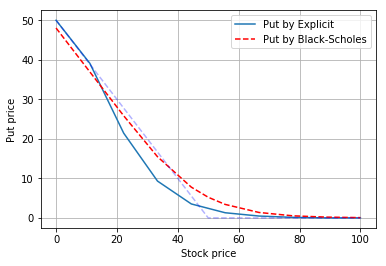

In [2]:
# Explicit - Put

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix
from scipy.interpolate import interp1d

S = 50; K = 50; T = 1; r = 0.1; v = 0.4;

Smax = 100; Smin = 0;
NS = 10; NT = 100; 
dS = (Smax-Smin)/(NS-1); dT = (T-0)/(NT-1);

P = np.zeros((NS,NT));
Stock = np.linspace(Smin,Smax,NS).reshape((NS,1));
P[0,:]  = K-Smin;
P[-1,:] = 0;
P[:,-1] = np.maximum(K-Stock,0).reshape((NS,));

span = np.arange(0,NS-2) 
a = 0.5*v**2*dT*((Smin/dS)+span)**2-0.5*r*dT*((Smin/dS)+span);
b = 1-r*dT-v**2*dT*((Smin/dS)+span**2);
c = 0.5*v**2*dT*((Smin/dS)+span)**2+0.5*r*dT*((Smin/dS)+span);
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html#scipy.sparse.dia_matrix
# dia_matrix((data, offsets), shape=(M, N))
data = [a, b, c];
offsets = [-1,0,1];
A = dia_matrix((data, offsets), shape=(NS, NS)); 

for t in range(NT-1,0,-1):
    P[1:-1,t-1] = (A@P[:,t])[1:-1];

x = np.linspace(Smin,Smax,NS); 
f = interp1d(Stock.reshape((NS,)), P[:,0], kind='cubic');
y = f(x)
plt.plot(x,y,label='Put by Explicit');

x1 = np.sort(np.append(x,K)); 
y1 = put(x1,K,r,v,T); 
plt.plot(x1,y1,'--r',label='Put by Black-Scholes'); 

y2 = np.maximum(K-x1,0);
plt.plot(x1,y2,'--b',alpha=0.3);

plt.legend()
plt.grid(True);
plt.xlabel('Stock price'); plt.ylabel('Put price')
plt.show()

In [ ]:
# Implicit - Put

S = 50; K = 50; T = 1; r = 0.1; v = 0.4; 

Smax = 100; Smin = 0;
NS = 10; NT = 100;
dS = (Smax-Smin)/(NS-1); dT = (T-0)/(NT-1);

C = zeros(NS,NT);
Stock = linspace(Smin,Smax,NS)';
C(1,:)  = 0;
C(NS,:) = (Stock(end)-K);
C(:,NT) = max(Stock-K,0);

a = -0.5*v^2*dT*((Smin/dS)+(1:NS-2)).^2+0.5*r*dT*((Smin/dS)+(1:NS-2));
b = 1+r*dT+v^2*dT*((Smin/dS)+(1:NS-2)).^2;
c = -0.5*v^2*dT*((Smin/dS)+(1:NS-2)).^2-0.5*r*dT*((Smin/dS)+(1:NS-2));
i = [(2:NS-2) (1:NS-2) (1:NS-3)];
j = [(1:NS-3) (1:NS-2) (2:NS-2)];
s = [a(2:NS-2) b c(1:NS-3)];
A = sparse(i,j,s);

for t=NT-1:-1:1
    d = zeros(NS-2,1); d(1) = a(1)*C(1,t); d(end) = c(end)*C(end,t);	
    C(2:end-1,t) = A\(C(2:end-1,t+1)-d);
end

x = linspace(Smin,Smax,NS)'; y = interp1(Stock, C(:,1), x);
x1 = sort([x; K]); y1 = Call(x1,K,T,r,v); y2 = max(x1-K,0);
plot(x,y,x1,y1,'-r',x1,y2,'--r'); grid on;
legend('Call by Implicit','Call by Black-Scholes')
xlabel('Stock price'); ylabel('Call price')